In [1]:
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from mpdaf.obj import Spectrum,WaveCoord,Cube,deg2sexa
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
from sklearn.preprocessing import minmax_scale

In [2]:
#General functions

#Wavelength to Velocity scale
c = 299792 #km/s
def lambda2vel(xLambda, restLambda):
    k = (xLambda / restLambda) ** 2
    return c *  (k - 1) / (k + 1) 

def vel2lambda(vel, restLambda):
    k = vel / c
    return restLambda * ((1+k)/(1-k))**0.5

#Guass fitting
def gauss_func(x, a, lmbda, sig, c, d):
    return a*m.exp(-(x-lmbda)**2/2/sig**2) + c*x + d

def double_peak_f(x, a1, a2, lmbda1, lmbda2, sig1, sig2, c, d):
    return a1*m.exp(-(x-lmbda1)**2/2/sig1**2) + a2*m.exp(-(x-lmbda2)**2/2/sig2**2) + c*x + d
double_peak = np.vectorize(double_peak_f)

#Return the signal to noise ratio of a particular fit result by mpdaf
def get_snr(fit, noise, step=1.25):
    rms = np.std(noise)
    fwhm = np.sqrt(((fit.fwhm)*2)*2/step)
    snr = fit.flux/(fwhm*rms)         
    return snr

#Print a horizonatl bar for separation
def hbar():
    print('―' * 117)

In [3]:
#Loading cube file, src_catalogue, line_catalogue
def load_cube_cat(cube_dir, cat_dir, lines_cat_dir):
    global cube, cat, lines_cat
    cube = Cube(cube_dir)                                                                      #input cube file
    hdul = fits.open(cat_dir)                                                                  #input source catalog
    cat = Table(hdul[1].data)
    hdul2 = fits.open(lines_cat_dir)                                                           #input line catalog
    lines_cat = Table(hdul2[1].data)

#Return the coordinate (ra, dec) from catalogue
def get_cood(id_in):
    row = cat[cat.field('iden')==id_in]
    return row['RA'][0], row['DEC'][0]

#Return a line catalogue of the specified source, arranged in descending order of provided SNR
def find_src_cat(id_in):
    src_cat = lines_cat[lines_cat.field('iden')==id_in]
    src_cat = src_cat[np.argsort(-src_cat['SNR'])]
    return src_cat

#Create source objects of the nth highest snr source
def create_sources(n):
    
    source_dict = {}
    
    #arrange lyalpha sources according to provided SNR 
    lyalpha = lines_cat[lines_cat.field('FAMILY')=='lyalpha']
    lyalpha = lyalpha[np.argsort(-lyalpha['SNR'])]
    
    for i in range(n):
        src_cat = find_src_cat(lyalpha['iden'][i])
        #source_dict[id_of_source]= line catalogue of this source
        source_dict[lyalpha['iden'][i]] = src_cat
    
    for iden, src_cat in source_dict.items():
        source_dict[iden] = Source(iden, src_cat)
        
    return source_dict




In [4]:
#Line Emission matching
def find_another(line_in, line_list):
    for line in line_list:
        if line_in.cat==line.cat and line!=line_in:
            return line
    return None

#Row info of a particular emission line of the specified source
def get_emission_line_row(id_in, line_name):
    src_cat = find_src_cat(id_in)
    row = src_cat[src_cat.field('LINE')==line_name]
    row = row[row.field('FAMILY')!='abs']
    return row

#Return the range of a doublet if applicable
def get_range(cat):
    if type(cat) == tuple:
        return cat[0].left, cat[1].right
    else:
        return cat.left, cat.right

In [58]:
#Finding Apeture
#offset_dict = {}

dev = {}
dev['PRIOR'] = (5, -10)
dev['MUSELET'] = (0, 0)


#Extract subcube of the specified source

            
def get_subcube(id_in, idfrom):
    cube_used = cube
    ra, dec = get_cood(id_in)
    dev_x, dev_y = dev[idfrom]
    subcube = cube_used.subcube((dec + dev_y*0.2/3600, ra - dev_x*0.2/3600), 8)
    return subcube

def get_spe(id_in, idfrom):
    cube_used = cube
    ra, dec = get_cood(id_in)
    dev_x, dev_y = dev[idfrom]
    spe = cube_used.aperture((dec + dev_y*0.2/3600, ra - dev_x*0.2/3600), .4, is_sum=True)
    return spe

def find_cube(cood_in):
    pass

def max_flux():
    pass

In [59]:
# Inputs are the id, name, rest wavelength, observed wavelength, and range
class Lines:
    def __init__(self,id_in, name, rest, obs, left, right):
        self.id = id_in
        self.name = name
        self.cat = name[:-4]
        self.rest = rest
        self.obs = obs
        self.left = left - 4*(obs - left)
        self.right = right + 4*(right - obs) 
        self.fit = None
        
    
    def get_subspe(self, spe=None):
        if spe == None:
            spe = get_spe(self.id)
            
        cleft = vel2lambda(lambda2vel(self.obs, self.rest)-300, self.rest) 
        cright = vel2lambda(lambda2vel(self.obs, self.rest)+300, self.rest) 
        return spe.subspec(lmin=cleft, lmax=cright)
        
    
    def plot_vel(self, spe, ax_in=None):

        subspe = self.get_subspe(spe)
        
        xrange = np.arange(subspe.wave.get_start(), subspe.wave.get_end()+.01, subspe.wave.get_step())
        xvel = np.array([lambda2vel(i, self.rest) for i in xrange])
        central_v = lambda2vel(self.obs, self.rest)


        if ax_in == None:
            fig, ax_in = plt.subplots()
        
        
        ax_in.step(xvel, minmax_scale(subspe.data), where='mid', label=self.name)
        ax_in.axvline(x=central_v, color='r', label='velocity of line at peak of gaussian')
        ax_in.set_xlabel("Velocity scale (km/s)")
        ax_in.legend(loc='upper right')

            

In [60]:
#Inputs are the id, coordinates and the line catalogue of this source
class Source:
    def __init__(self, id_in, src_cat):
        
        #Basic info from catalogue
        self.id = id_in
        ra, dec = get_cood(self.id)
        self.idfrom = src_cat[0]['idfrom']
        
        #If the lya is double peak
        #self.is_double_peak = id_in in double_peak_src
        
        #Extracting Spectrum and Subcube

        self.subcube = get_subcube(self.id, self.idfrom)

        self.spe = get_spe(self.id, self.idfrom)
        self.step = self.spe.wave.get_step()
            
        #Creating a list of line emission class arranged in SNR>3
        self.src_cat = src_cat[src_cat.field('SNR')>3.]
        
        self.line_list = []
        for i in range(len(self.src_cat)):
            self.line_list.append(Lines(self.id, self.src_cat['LINE'][i], self.src_cat['LBDA_REST'][i], 
                                        self.src_cat['LBDA_OBS'][i], self.src_cat['LBDA_LEFT'][i], 
                                       self.src_cat['LBDA_RIGHT'][i]))
        
        #Regrouping the line_list to a category dictionary
        self.cat_dict = {}
        for line in self.line_list:
            if line.cat in self.line_list:
                continue
            another_line = self.find_another(line)
            if another_line != None:
                #arrange the lines by their wavelength
                if line.rest < another_line.rest:
                    self.cat_dict[line.cat] = (line, another_line)
                else:
                    self.cat_dict[line.cat] = (another_line, line)
            else:
                self.cat_dict[line.cat] = line
        
        self.plot_lya()
    
    #Line Emission matching
    def find_another(self, line_in):
        for line in self.line_list:
            if line_in.cat==line.cat and line!=line_in:
                return line
        return None

    #Masking unwanted features
    def deploy_mask():
        pass
    
    #Return the line range of a doublet if applicable
    def get_lrange(self, cat_name):
        cat = self.cat_dict[cat_name]
        if type(cat) == tuple:
            return cat[0].left, cat[1].right
        else:
            return cat.left, cat.right
      
    #Return the crop range of a doublet spe if applicable
    def get_crange(self, cat_name):
        lleft, lright = self.get_lrange(cat_name)
        return lleft-50, lright+50
    
        
        
    #Return spectrum of a particular cat
    def get_subspe(self, cat_name):
        cleft, cright = self.get_crange(cat_name)
        return self.spe.subspec(lmin=cleft, lmax=cright, unit=u.angstrom)
    
    #Ungroup cat_dict to individual lines
    def ungroup(self):
        result = []
        for cat, line in self.cat_dict.items():
            if type(line) == tuple:
                result.append(line[0])
                result.append(line[1])
            else:
                result.append(line)
                
        return result
    
    #Determine which fit method will be used    
    def which_fit_method(self, cat_name):
        cat = self.cat_dict[cat_name]
        if type(cat) == tuple:
            return 'doublet'
        
        #Check if the lya is double peak
        
        #elif cat.name == 'LYALPHA' and self.is_double_peak:
            #return 'double_peak'
        
        #Single line emission
        return 'single'

    
    #Peform the suitable fitting routine with standardized output
    def get_fit(self, cat_name, spe=None, plot=True, ax_in=None):
        
        cat = self.cat_dict[cat_name]
        method = self.which_fit_method(cat_name)
        lleft, lright = self.get_lrange(cat_name)
        cleft, cright = self.get_crange(cat_name)
        
        if spe == None:
            spe = self.get_subspe(cat_name)
        
        if method == 'doublet':
            fit = spe.gauss_dfit(lmin=(cleft, lleft), lmax=(lright, cright),wratio=cat[1].rest/cat[0].rest,
                                 lpeak_1=cat[0].obs, plot=plot)
            cat[0].fit = fit[0]
            cat[1].fit = fit[1]
            
        elif method == 'single':
            fit = spe.gauss_fit(lmin=(cleft,lleft), lmax=(lright,cright), lpeak=cat.obs, plot=plot)
            
            cat.fit = fit
            
        return fit
    
    #Modular plot methods
    def plot_img(self, cat_name, ax_in=None):
        cleft, cright = self.get_lrange(cat_name)
        line_cube = self.subcube.select_lambda(cleft, cright)
        line_img = line_cube.mean(axis=0)
        
        if ax_in == None:
            fig, ax_in = plt.subplots()
                                 
        line_img.plot(colorbar='v', vmin=0, vmax=line_img[20,20]*1.2, title=f"id{self.id} {cat_name} ({self.idfrom})", 
                      ax=ax_in)
        circle = plt.Circle((20,20),2,fill=False, color='b')
        ax_in.add_artist(circle)

    def plot_spe(self, cat_name, ax_in=None, fit=True):
        
        cat = self.cat_dict[cat_name]
        
        if ax_in == None:
            fig, ax_in = plt.subplots()
            
        spe = self.get_subspe(cat_name)
        spe.plot(ax=ax_in)
        
        if fit:
            gauss = self.get_fit(cat_name, spe, ax_in=ax_in)
            noise = []
            lleft, lright = self.get_lrange(cat_name)
            cleft, cright = self.get_crange(cat_name)
            wl = np.arange(spe.wave.get_start(),spe.wave.get_end()+0.01,spe.wave.get_step())
            wlrange1 = np.logical_and(cleft < wl,wl < lleft)
            wlrange2 = np.logical_and(lright < wl,wl < cright)
            ax_in.step(wl[wlrange1],spe.data[wlrange1],where='mid',color='black')
            ax_in.step(wl[wlrange2],spe.data[wlrange2],where='mid',color='black')
            noise.append(spe.data[wlrange1])
            noise.append(spe.data[wlrange2])
        
        method = self.which_fit_method(cat_name)
        if method == 'single':
            
            if fit:
                snr = get_snr(gauss, noise, step=self.step)
                ax_in.axvline(gauss.lpeak,color='blue',label='line position at peak of gaussian')
                ax_in.axvspan(gauss.lpeak-gauss.err_lpeak,gauss.lpeak+gauss.err_lpeak,alpha=0.3)
            else:
                snr = None
            
            ax_in.set_title(f"{cat.name}  SNR={snr}")
            ax_in.axvline(cat.obs,color='red',label='observed wavelength listed in catalog')
            
            ax_in.legend(loc='upper right')
        
        elif method == 'doublet':
            
            if fit:
                snr0 = get_snr(gauss[0], noise, step=self.step)
                snr1 = get_snr(gauss[1], noise, step=self.step)
                
                ax_in.axvline(gauss[0].lpeak,color='blue',label='line position at peak of gaussian')
                ax_in.axvline(gauss[1].lpeak,color='blue')
            
                ax_in.axvspan(gauss[0].lpeak-gauss[0].err_lpeak,gauss[0].lpeak+gauss[0].err_lpeak,alpha=0.3)
                ax_in.axvspan(gauss[1].lpeak-gauss[1].err_lpeak,gauss[1].lpeak+gauss[1].err_lpeak,alpha=0.3)
            
                ax_in.set_title(f"{cat[0].name}, {cat[1].name}  SNR={snr0}, {snr1}")      ##tabbed to right
                ax_in.axvline(cat[0].obs, color='red', label='observed wavelength listed in catalog') ##tabbed to right
                ax_in.axvline(cat[1].obs, color='red')  ##tabbed to right
            
                ax_in.legend(loc='upper right') ##tabbed to right
            
        else:
            pass
    
    # Present methods
    
    def plot_lya(self):
        fig, axes = plt.subplots(1, 2)
        fig.set_size_inches(18.5, 5, forward=True)
        self.plot_img('LYA', axes[0])
        self.plot_spe('LYA', axes[1], fit=False)        
    
    def plot_fit_all(self):
        
        for cat_name in self.cat_dict:
            fig, ax = plt.subplots(1, 1)
            fig.set_size_inches(18.5, 5, forward=True)
            self.plot_spe(cat_name, ax_in=ax)
    
    #Plotting image, spectrum, velocity scale side by side
    def plot_sidebyside(self):
        
        line_list = self.ungroup()
        
        for line in line_list:
            fig, axs = plt.subplots(1, 3)
            fig.set_size_inches(18.5, 5, forward=True)
            
            self.plot_img(line.cat, axs[0])
            self.plot_spe(line.cat, axs[1])
            line.plot_vel(self.spe, axs[2])
            plt.show()
    
    def plot_sharex(self):
        
        line_list = self.ungroup()
        
        fig, axs = plt.subplots(len(line_list), 1, sharex=True)
        # Remove horizontal space between axes
        fig.subplots_adjust(hspace=0)
        fig.set_size_inches(10.5, 2.1*len(line_list), forward=True)
        fig.set_dpi(120)
        axs[0].set(title=f"Velocity plots of emission lines from id{self.id}")
        
        counter = 0
        for line in line_list:
            line.plot_vel(self.spe, ax_in=axs[counter])
            counter += 1
        plt.show()


In [61]:
#Identify presence of lya double peak manually
double_peak_src = (2861)

In [62]:
load_cube_cat("C:\Isha\YUNEE\RESEARCH\ADP.2017-06-19T11_32_26.411.fits", 
              "C:\Isha\YUNEE\RESEARCH\MACS1206_v1.0.fits",
              "C:\Isha\YUNEE\RESEARCH\MACS1206_v1.0_lines.fits")

[INFO] 16 spaxels used
[INFO] 16 spaxels used
[INFO] 16 spaxels used
[INFO] 16 spaxels used
[INFO] 16 spaxels used


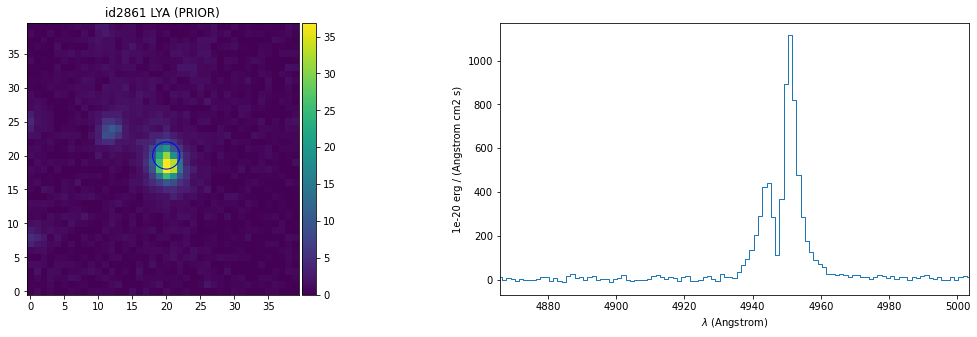

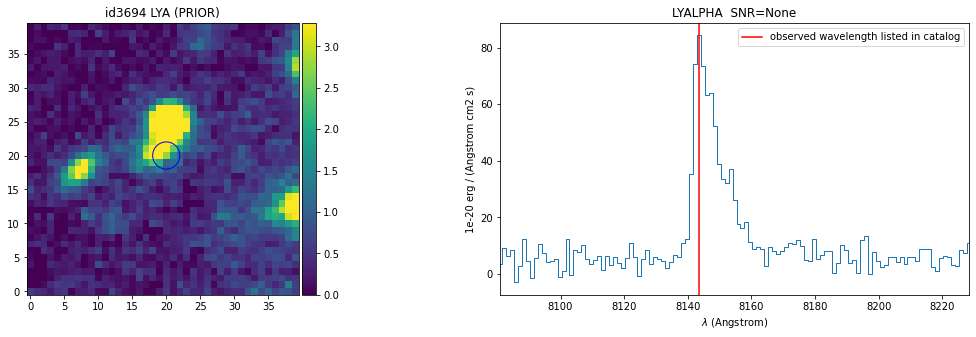

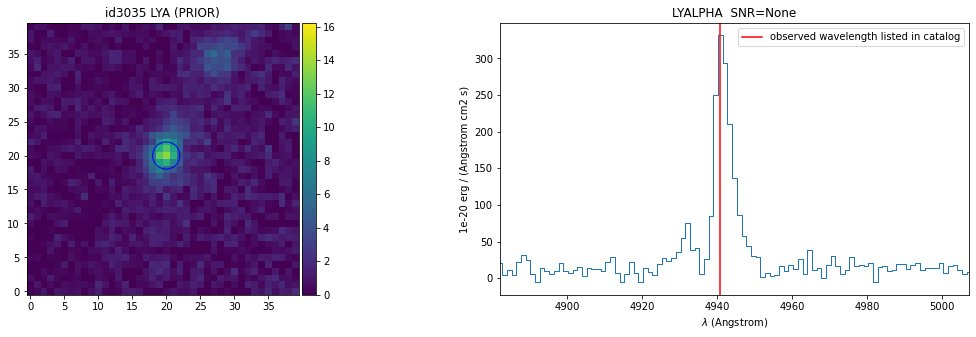

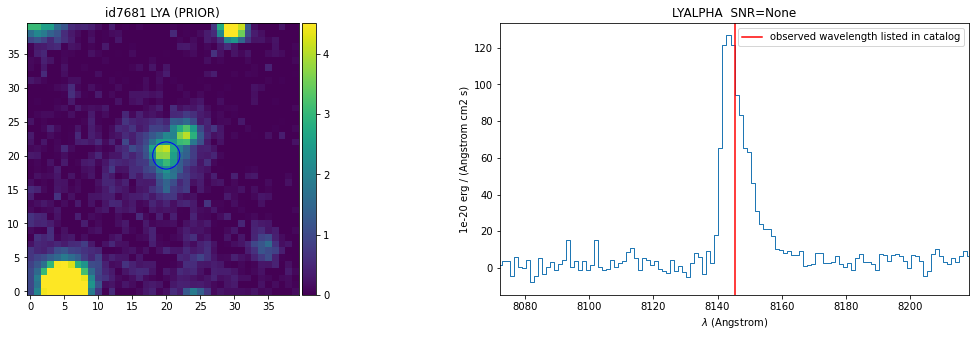

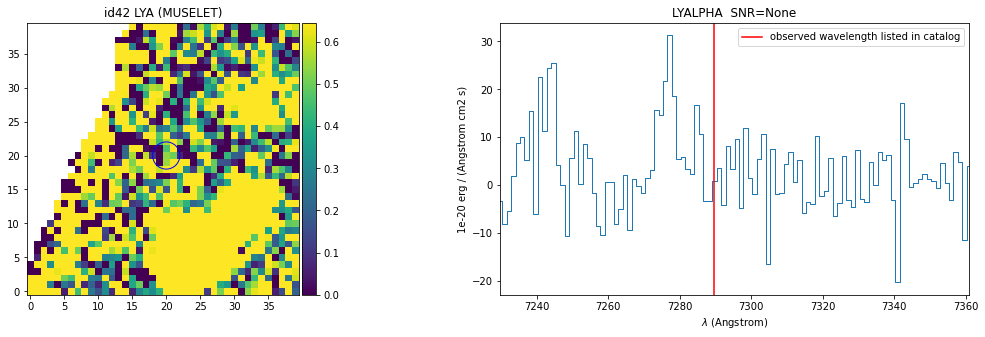

In [63]:
#Initialize sources
source_dict = create_sources(5)

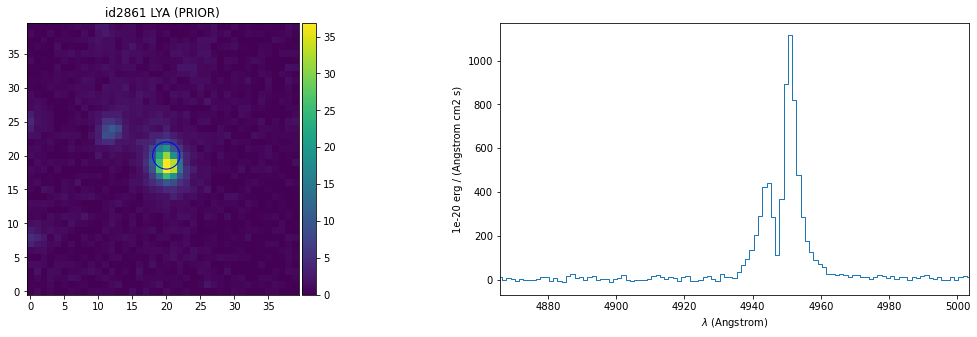

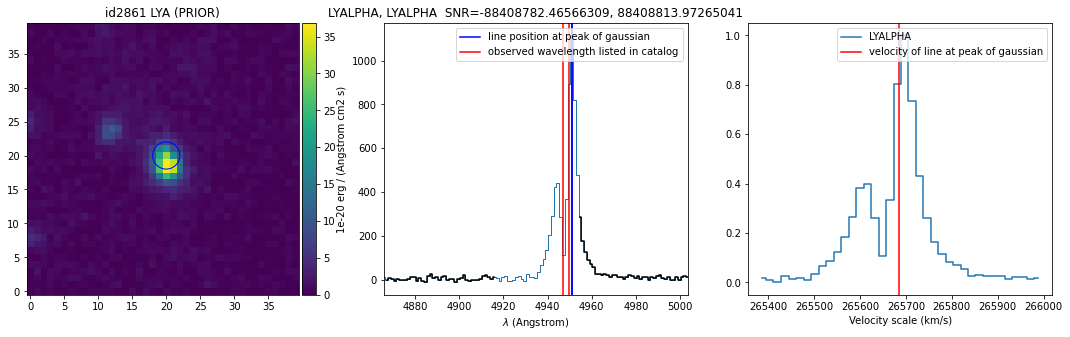

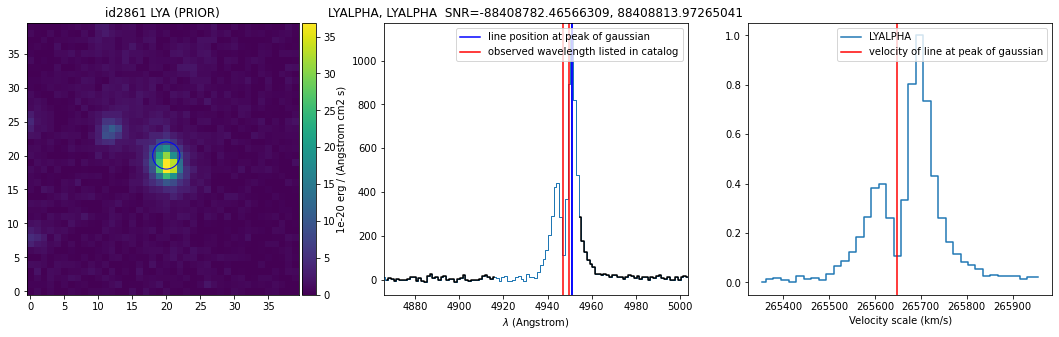

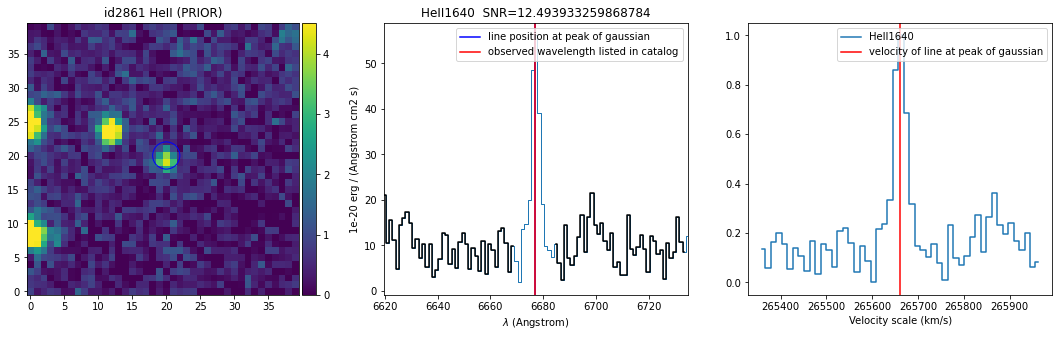

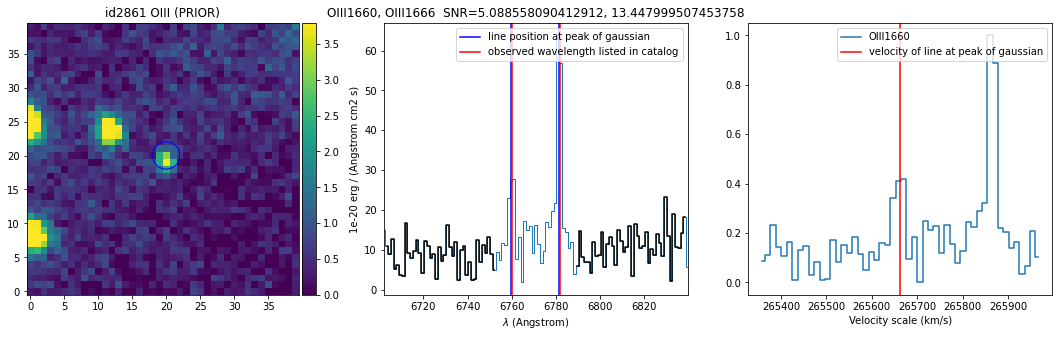

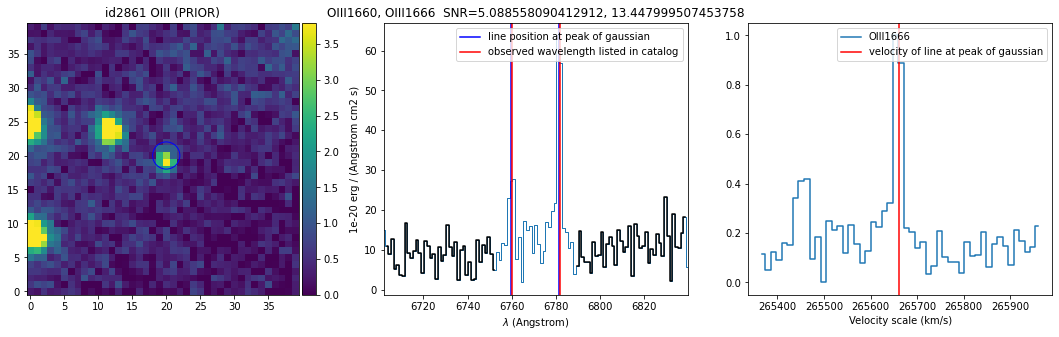

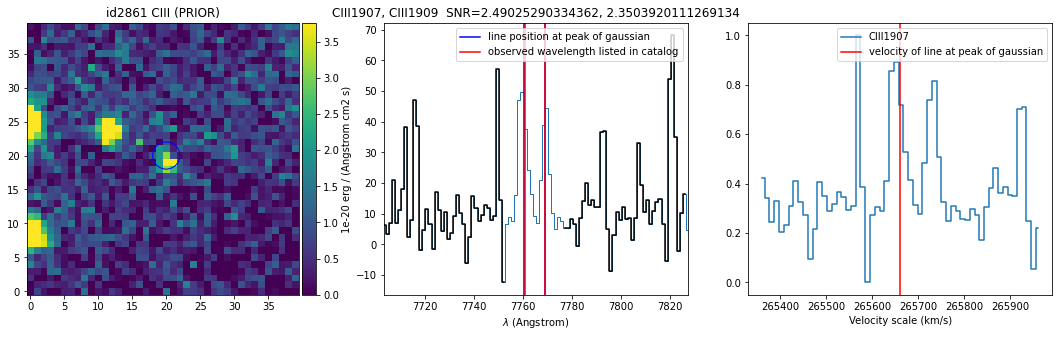

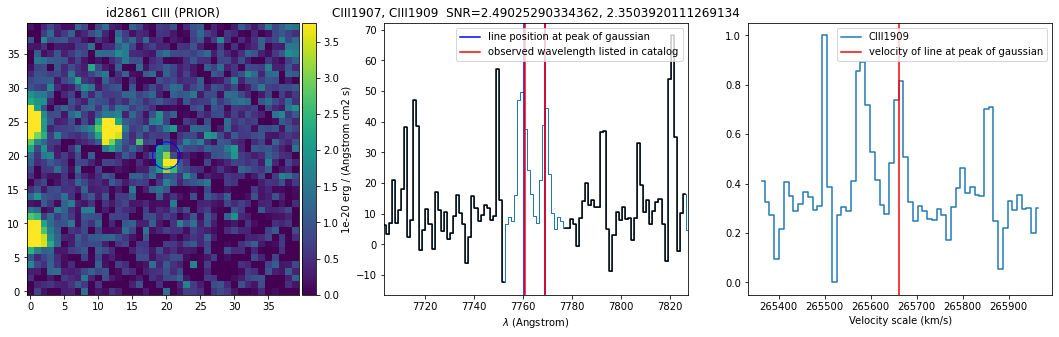

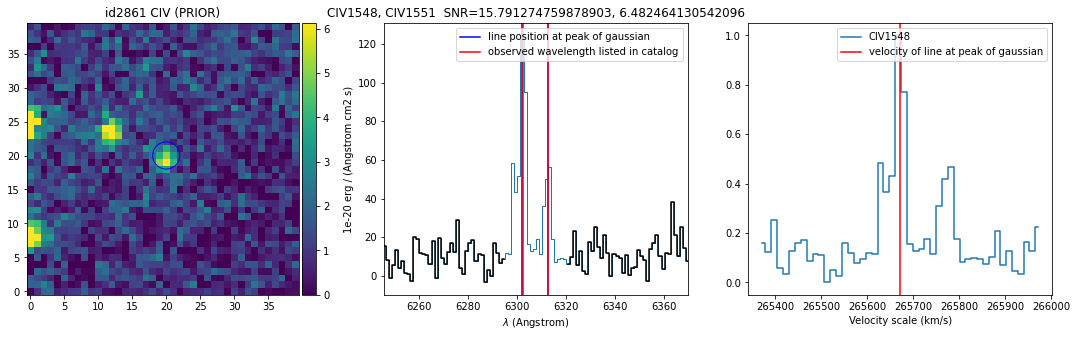

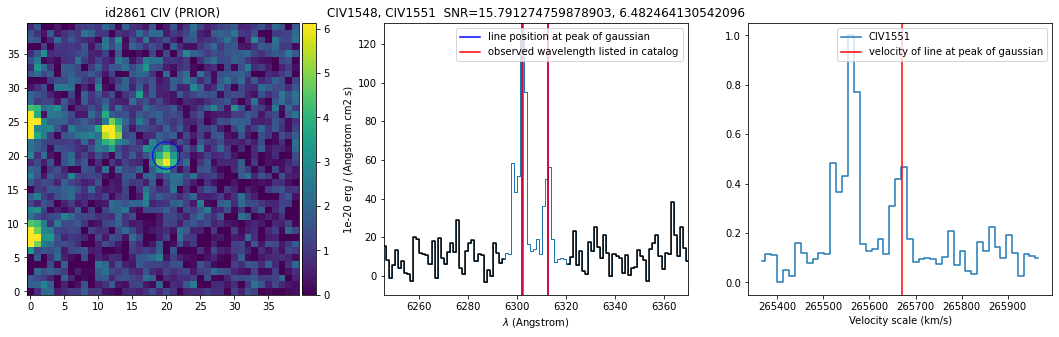

In [65]:
#Interact with sources individually
src4556 = source_dict[2861]
src4556.plot_lya()
src4556.plot_sidebyside()

In [ ]:
#1400, 60, 250, 100
#1000, 80, 300, 120